# Meta-analysis

Meta-analysis is used to combine evidence from multiple studies, usually clinical trials testing the effectiveness of therapies or tests. The pooled evidence from multiple studies can give much more precise and reliable answers than any single study can. Although many researchers are convinced that meta-analyses are hugely important and helpful, others doubt that meta-analysis can consistently overcome the huge challenges and produce consistently useful results:

- inconsistent criteria to define a disease => define which patients are included
- different outcome variables => define which outcomes are included
- unpublished studies/publication bias => seek unpublished data, review registries of study protocols
- some studies are of higher quality than others => define what makes a study of high enough quality to be included
- different languages => arrange for translation
- not enough information to perform a proper analysis => estimate data from figures, obtain unpublished details from investigators
- published data may be internally inconsistent => resolve inconsistencies without bias, request details from investigators
- data from some patients may be included in multiple publications, redundant analyses => ask investigators to clarify which patients were included in more than one publication

A meta-analysis pools weighted effect sizes, it calculates a pooled P value from the pooled effect size.

Meta-analyses don't have to be huge, it can be helpful to combine the results from as few as two studies.

## Assumptions of meta-analysis

There are two general methods that are used, each of which is based on different assumptions:

- _fixed effects_: this model assumes that all the subjects in all the studies were really sampled from one large population. Thus, all teh studies are estimating the same effect, and the only difference between studies is due to random selection of subjects.
- _random effects_: this model assumes that each study population is unique. The difference among study results is due both to differences between the populations and to random selection of subjects. This model is more realistic and is used more frequently.

In [48]:
# We use the data extracted from Figure 43.1 on page 455
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats

In [2]:
mean = np.array([2.5, 1.4, 1.1, 1.2,  .8,  .8, 1.1, np.NaN, 1.2])
lower= np.array([1.8,  .8,  .8,  .8,  .5,  .4,  .6, np.NaN,  .9])
upper= np.array([4.4, 2.2, 1.8, 1.9, 1.4, 1.6, 2,   np.NaN, 1.4])
W = (upper-lower)/2

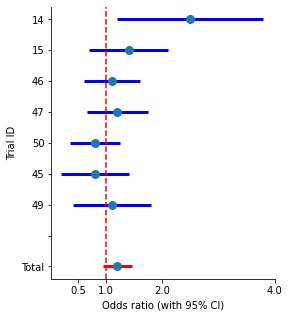

In [3]:
plt.figure(figsize=(4,5))
plt.errorbar(
    x=np.flip(mean),
    y=np.arange(len(mean)),
    xerr=np.flip(W),
    fmt='o',
    ms=8,
    ecolor=['red']+['blue']*8,
    elinewidth=3,
)

plt.xlabel("Odds ratio (with 95% CI)")
plt.xticks([0.5, 1, 2, 4.0])
plt.ylabel("Trial ID")
plt.yticks(
    list(range(0,9)),
    ['Total', '', '49', '45', '50', '47', '46', '15', '14'])
plt.axvline(x=1, color='red', linestyle='--')
sns.despine();

## Results from a meta-analysis

Part of a meta-analysis is a narrative report that summarizes the studies that have been done and evaluates their strengths and weaknesses. The rest of a meta-analysis is quantitative. The results of each study are summarized by one value, called the **effect size**, along with its CI. The effect size is usually a relative risk or odds ratio, but it could also be some other measure of treatment effect. Combining all the studies, the meta-analysis computes the pooled treatment effect, its CI and a pooled P value.

The results for the individual studies and the pooled results are plotted on a **forest plot** or **blobbogram**.

In the example above, the forest plot shows the results from 7 studies of the effectiveness of a drug, the horizontal axis is the odds ratio, a value of 1.0 means no effect; a value greater than 1.0 means the drug works better than placebo. The top 7 lines are results of individual studies. For each study, the plot shows the odds ratio and 95% confidence interval. At the very bottom, the graph shows the total (pooled) effect computed from all studies, also shown as an odds ratio with its 95% CI.

In 6 of the 7 studies, the 95% CI includes 1.0. With 95% confidence, you cannot conclude from these six studies that the treatment works better than placebo. In only 1 of the studies, does the 95% CI not include 1.0. The data from this study, but not the others, would lead you to conclude with 95% confidence that the treatment worked better than placebo. The bottom part of the graph shows the total (pooled) effect as computed by the meta-analysis. The 95% CI ranges from 0.98 to 1.56, so the P value must be greater than 0.05. The overall odds ratio is 1.24. That is a small effect, but not a tiny one. The 95% CI includes 1.0 (no effect), but just barely.

## Implementation in Python

Statsmodels include basic methods for [meta-analysis](https://www.statsmodels.org/stable/examples/notebooks/generated/metaanalysis1.html). The support for meta-analysis has 3 parts:

- effect size functions: this currently includes `effectsize_smd` computes effect size and their standard errors for standardized mean difference, `effectsize_2proportions` computes effect sizes for comparing two independent proportions using risk difference, (log) risk ratio, (log) odds-ratio or arcsine square root transformation
- The `combine_effects` computes **fixed and random effects estimate** for the overall mean or effect. The returned results instance includes a forest plot function.
- helper functions to estimate the random effect variance, tau-squared

In [4]:
from statsmodels.stats.meta_analysis import (
    effectsize_smd,
    effectsize_2proportions,
    combine_effects,
)

In [5]:
data = [
    ["Carroll", 94, 22, 60, 92, 20, 60],
    ["Grant", 98, 21, 65, 92, 22, 65],
    ["Peck", 98, 28, 40, 88, 26, 40],
    ["Donat", 94, 19, 200, 82, 17, 200],
    ["Stewart", 98, 21, 50, 88, 22, 45],
    ["Young", 96, 21, 85, 92, 22, 85],
]
colnames = ["study", "mean_t", "sd_t", "n_t", "mean_c", "sd_c", "n_c"]
dframe1 = pd.DataFrame(data[1:], columns=colnames).set_index('study')

mean2, sd2, nobs2, mean1, sd1, nobs1 = np.asarray(
    dframe1
).T

In [6]:
dframe1

,mean_t,sd_t,n_t,mean_c,sd_c,n_c
study,,,,,,
Grant,98,21,65,92,22,65
Peck,98,28,40,88,26,40
Donat,94,19,200,82,17,200
Stewart,98,21,50,88,22,45
Young,96,21,85,92,22,85


In [7]:
# one-step chi2, DerSimonian-Laird estimate for random effects variance tau
eff1, var_eff1 = effectsize_smd(mean2, sd2, nobs2, mean1, sd1, nobs1)

In [8]:
eff1

array([0.2773564 , 0.36654635, 0.6643851 , 0.46180798, 0.18516464])

In [9]:
#Uone-step chi2, DerSimonian-Laird estimate for random effects variance tau
res1 = combine_effects(eff1, var_eff1, method_re="chi2", use_t=True, row_names=dframe1.index)

In [144]:
print("method RE:", res1.method_re)
print("tau2=", res1.tau2)

method RE: chi2
tau2= 0.028952649938462235


In [10]:
print(res1.summary_frame())

                        eff    sd_eff    ci_low    ci_upp      w_fe      w_re
Grant              0.277356  0.176279 -0.068144  0.622857  0.151858  0.190752
Peck               0.366546  0.225573 -0.075569  0.808662  0.092739  0.143423
Donat              0.664385  0.102748  0.463002  0.865768  0.446980  0.289808
Stewart            0.461808  0.208310  0.053527  0.870089  0.108747  0.158271
Young              0.185165  0.153729 -0.116139  0.486468  0.199676  0.217747
fixed effect       0.460272  0.068694  0.269547  0.650997  1.000000       NaN
random effect      0.411431  0.107006  0.114335  0.708527       NaN  1.000000
fixed effect wls   0.460272  0.099537  0.183914  0.736630  1.000000       NaN
random effect wls  0.411431  0.091939  0.156168  0.666694       NaN  1.000000


C:\Users\WIECKOWS\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\stats\meta_analysis.py:106: UserWarning: `use_t=True` requires `nobs` for each sample or `ci_func`. Using normal distribution for confidence interval of individual samples.
  warnings.warn(msg)


In [11]:
res1.conf_int_samples(nobs=np.array(nobs1 + nobs2))

(array([-0.07141628, -0.08244568,  0.46238908,  0.04820269, -0.1183121 ]),
 array([0.62612908, 0.81553838, 0.86638112, 0.87541326, 0.48864139]))

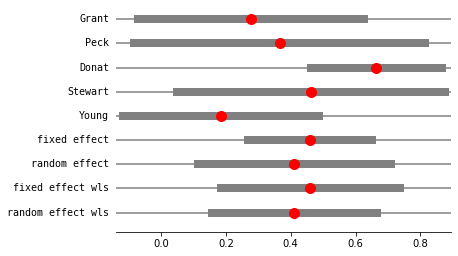

In [12]:
fig = res1.plot_forest()

### Another example with the effect being the mean of measurements (fixed-effect)

In [13]:
eff2 = np.array(
    [61.00,  61.40,  62.21,  62.30,  62.34,  62.60,  62.70,  62.84,  65.90 ]
)
var_eff2 = np.array(
    [0.2025, 1.2100, 0.0900, 0.2025, 0.3844, 0.5625, 0.0676, 0.0225, 1.8225]
)
rownames2 = [
    "PTB",   "NMi",  "NIMC", "KRISS","LGC",  "NRC",  "IRMM", "NIST", "LNE" 
]

                         eff    sd_eff     ci_low     ci_upp      w_fe  \
PTB                61.000000  0.450000  60.118016  61.881984  0.057436   
NMi                61.400000  1.100000  59.244040  63.555960  0.009612   
NIMC               62.210000  0.300000  61.622011  62.797989  0.129230   
KRISS              62.300000  0.450000  61.418016  63.181984  0.057436   
LGC                62.340000  0.620000  61.124822  63.555178  0.030257   
NRC                62.600000  0.750000  61.130027  64.069973  0.020677   
IRMM               62.700000  0.260000  62.190409  63.209591  0.172052   
NIST               62.840000  0.150000  62.546005  63.133995  0.516920   
LNE                65.900000  1.350000  63.254049  68.545951  0.006382   
fixed effect       62.583397  0.107846  62.334704  62.832090  1.000000   
random effect      62.390139  0.245750  61.823439  62.956838       NaN   
fixed effect wls   62.583397  0.189889  62.145512  63.021282  1.000000   
random effect wls  62.390139  0.294776

C:\Users\WIECKOWS\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\stats\meta_analysis.py:106: UserWarning: `use_t=True` requires `nobs` for each sample or `ci_func`. Using normal distribution for confidence interval of individual samples.
  warnings.warn(msg)


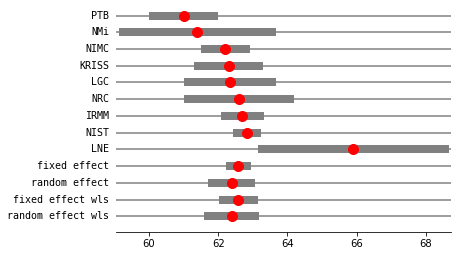

In [143]:
res2_DL = combine_effects(eff2, var_eff2, method_re="dl", use_t=True, row_names=rownames2)
print(res2_DL.summary_frame())
fig = res2_DL.plot_forest()

### Step-by-step Woolf method (fixed-effect)

A very common and simple version of the meta-analysis procedure is commonly referred to as the inverse-variance method. This approach is implemented in its most basic form in RevMan, and is used behind the scenes in many meta-analyses of both dichotomous and continuous data.

The inverse-variance method is so named because the weight given to each study is chosen to be the inverse of the variance of the effect estimate (i.e. 1 over the square of its standard error). Thus, larger studies, which have smaller standard errors, are given more weight than smaller studies, which have larger standard errors. This choice of weights minimizes the imprecision (uncertainty) of the pooled effect estimate.

We assign **weights** based on the inverse of the variance rather than sample size. The inverse variance is roughly proportional to sample size, but is a more nuanced measure, and serves to minimize the variance of the combined effect so that $ w_i = \frac{1}{v_i} $ with $v_i$ the within-study variance for studi $i$.

A fixed-effect meta-analysis using the inverse-variance method calculates a weighted average as, i.e. the weighted mean is then computed as the sum of the products $w_iE_i$, where $E_i$ is the effect size if the individual study, divided by the sum of the weights:

$$ \bar{E} = \frac{\sum_{i=1}^kw_iE_i}{\sum_{i=1}^kw_i} = \frac{\sum E_i(1/\mathrm{SE_i}^2)}{\sum (1/\mathrm{SE_i}^2)} $$

A fixed-effect meta-analysis is valid under an assumption that all effect estimates are estimating the same underlying intervention effect, which is referred to variously as a 'fixed-effect' assumption, a 'common-effect' assumption or an 'equal-effects' assumption.

The variance of the combined effect is $ v = \frac{1}{\sum_{i=1}^kw_i} $, and $ \mathrm{SE}(\bar{E}) = \sqrt{v} $.

The 95% confidence interval for the mean combined effect would then be $ \bar{E} \pm z_{\alpha/2}*\mathrm{SE}(\bar{E}) $ (see the video ["Meta-analysis Prediction Intervals"](https://www.youtube.com/watch?v=DPo88xtPUaA)), it tells nothing about the distribution of the different effect sizes measured but the precision of the mean effect sizes, depending on the number of studies.

Finally, $ Z = \frac{\bar{E}}{\mathrm{SE}(\bar{E})} $, so for a two-tailed test $ p = 2[1-(\phi(|Z|))] $ with $\phi$ the standard normal cumulative function. In the context of Cochrane reviews is either an assumption of 'no effect of the intervention' or 'no differences in the effect of intervention between studies' (_no heterogeneity_). Thus, a P value that is very small indicates that the observed effect is very unlikely to have arisen purely by chance, and therefore provides evidence against the null hypothesis. 

In [30]:
weights2 = 1 / var_eff2
weights2

array([ 4.9382716 ,  0.82644628, 11.11111111,  4.9382716 ,  2.60145682,
        1.77777778, 14.79289941, 44.44444444,  0.54869684])

In [34]:
# getting weights from the combined results
res2_DL.weights_fe

array([ 4.9382716 ,  0.82644628, 11.11111111,  4.9382716 ,  2.60145682,
        1.77777778, 14.79289941, 44.44444444,  0.54869684])

In [45]:
# below corresponds to the `w_fe` column
res2_DL.weights_fe / sum(res2_DL.weights_fe)

array([0.05743554, 0.00961215, 0.12922996, 0.05743554, 0.03025675,
       0.02067679, 0.17205172, 0.51691983, 0.00638173])

In [54]:
T2 = eff2 * weights2
T2

array([ 301.2345679 ,   50.74380165,  691.22222222,  307.65432099,
        162.1748179 ,  111.28888889,  927.5147929 , 2792.88888889,
         36.15912209])

In [142]:
df2 = len(eff2) - 1

T_bar2 = sum(T2) / sum(weights2)
var_bar2 = 1 / sum(weights2)
SE_bar2 = var_bar2**.5
t_crit2 = stats.t(df=df2).ppf((1+.95)/2)

Z2 = T_bar2/SE_bar2

pvalue_2 = 2 * (1 - stats.t.cdf(x = abs(Z2), df=df2))

print(f"Combined effect size = {T_bar2:.4f} with SE = {SE_bar2:.4f} and the 95% CI ranging from {T_bar2 - t_crit2*SE_bar2:.4f} to {T_bar2 + t_crit2*se_bar2:.4f}")
print(f"Z statistic = {Z2:.2f} with an associated P value = {pvalue_2:.5f}")

Combined effect size = 62.5834 with SE = 0.1078 and the 95% CI ranging from 62.3347 to 62.8321
Z statistic = 580.30 with an associated P value = 0.00000


### Heterogeneity

The classical measure of heterogeneity is **Cochran's $Q$**, which is calculated as the weighted sum of squared differences between individual study effects and the pooled effect across studies, with the weights being those used in the pooling method with $ Q = \sum w(E_i-E)^2 $ where $ E = \frac{\sum w_iT_i}{\sum w_i} $.

$Q$ is distributed as a chi-square statistic with k (numer of studies) minus 1 degrees of freedom $Q \sim \chi^2(k-1)$.

$Q$ has low power as a comprehensive test of heterogeneity, especially when the number of studies is small, i.e. most meta-analyses. Conversely, $Q$ has too much power as a test of heterogeneity if the number of studies is large.

The $I^2$ statistic describes the percentage of variation across studies that is due to heterogeneity rather than chance, with $ I^2 = 100\%  \frac{Q - df}{Q} $. $I^2$ is an intuitive and simple expression of the inconsistency of studies' results. Unlike $Q$ it does not inherently depend upon the number of studies considered.

A confidence interval for $I^2$ is constructed using either i) the iterative non-central chi-squared distribution method of Hedges and Piggott; or ii) the test-based method of Higgins and Thompson. The non-central chi-square method is currently the method of choice.

In [148]:
res2_DL.test_homogeneity()

<class 'statsmodels.stats.base.HolderTuple'>
statistic = 24.80189774185419
pvalue = 0.001679351463714887
df = 8
distr = 'chi2'
tuple = (24.80189774185419, 0.001679351463714887)

In [162]:
Q2 = sum(res2_DL.weights_fe * (res2_DL.effect - res2_DL.mean_effect_fe)**2)
I2 = (Q2 - df2)/Q2
pvalue_homogen = 1 - stats.chi2.cdf(x = Q2, df=df2)

print(f"Cochrane Q = {Q2:.2f} and I² = {100*I2:.2f}%, with P value for homogeneitiy = {pvalue_homogen:.4f}")

Cochrane Q = 24.80 and I² = 67.74%, with P value for homogeneitiy = 0.0017


In [152]:
res2_DL.i2

0.6774440374173594

### Random-effects models

A variation on the inverse-variance method is to incorporate an assumption that the different studies are estimating different, yet related, intervention effects. This produces a random-effects meta-analysis, and the simplest version is known as the _DerSimonian and Laird method_.

The random-effects meta-analysis approach incorporates an assumption that the different studies are estimating different, yet related, intervention effects. The approach allows us to address heterogeneity that cannot readily be explained by other factors. A random-effects meta-analysis model involves an assumption that the effects being estimated in the different studies follow some distribution. The model represents our lack of knowledge about why real, or apparent, intervention effects differ, by considering the differences as if they were random. The centre of the assumed distribution describes the average of the effects, while its width describes the degree of heterogeneity. The conventional choice of _distribution is a normal distribution_. It is difficult to establish the validity of any particular distributional assumption, and this is a common criticism of random-effects meta-analyses. The importance of the assumed shape for this distribution has not been widely studied.

To undertake a random-effects meta-analysis, the standard errors of the study-specific estimates ($\mathrm{SE}_i$) are adjusted to incorporate a measure of the extent of variation, or heterogeneity, among the intervention effects observed in different studies (this variation is often referred to as Tau-squared, $\tau^2$, or Tau2). The amount of variation, and hence the adjustment, can be estimated from the intervention effects and standard errors of the studies included in the meta-analysis.

In a heterogeneous set of studies, a random-effects meta-analysis will award relatively more weight to smaller studies than such studies would receive in a fixed-effect meta-analysis. This is because small studies are more informative for learning about the distribution of effects across studies than for learning about an assumed common intervention effect.

Note that a random-effects model does not 'take account' of the heterogeneity, in the sense that it is no longer an issue. It is always preferable to explore possible causes of heterogeneity, although there may be too few studies to do this adequately.

If there is very little variation between trials then $I^2$ will be low and a fixed effects model might be appropriate. With fixed effects all of the studies that you are trying to examine as a whole are considered to have been conducted under similar conditions with similar subjects - in other words, the only difference between studies is their power to detect the outcome of interest. An alternative approach, 'random effects', allows the study outcomes to vary in a normal distribution between studies. Many investigators consider the random effects approach to be a more natural choice than fixed effects, for example in medical decision making contexts.

More data are required for random effects models to achieve the same statistical power as fixed effects models, and there is no 'exact' way to handle studies with small numbers when assuming random effects. This should not be a problem with most meta-analyses, however do not use random effects models with sparse datasets without expert statistical guidance.

## Meta-analysis of proportions

In [15]:
import io

ss = """\
    study,nei,nci,e1i,c1i,e2i,c2i,e3i,c3i,e4i,c4i
    1,19,22,16.0,20.0,11,12,4.0,8.0,4,3
    2,34,35,22.0,22.0,18,12,15.0,8.0,15,6
    3,72,68,44.0,40.0,21,15,10.0,3.0,3,0
    4,22,20,19.0,12.0,14,5,5.0,4.0,2,3
    5,70,32,62.0,27.0,42,13,26.0,6.0,15,5
    6,183,94,130.0,65.0,80,33,47.0,14.0,30,11
    7,26,50,24.0,30.0,13,18,5.0,10.0,3,9
    8,61,55,51.0,44.0,37,30,19.0,19.0,11,15
    9,36,25,30.0,17.0,23,12,13.0,4.0,10,4
    10,45,35,43.0,35.0,19,14,8.0,4.0,6,0
    11,246,208,169.0,139.0,106,76,67.0,42.0,51,35
    12,386,141,279.0,97.0,170,46,97.0,21.0,73,8
    13,59,32,56.0,30.0,34,17,21.0,9.0,20,7
    14,45,15,42.0,10.0,18,3,9.0,1.0,9,1
    15,14,18,14.0,18.0,13,14,12.0,13.0,9,12
    16,26,19,21.0,15.0,12,10,6.0,4.0,5,1
    17,74,75,,,42,40,,,23,30"""
df3 = pd.read_csv(io.StringIO(ss))
df3_sub = df3[["e2i", "nei", "c2i", "nci"]]

count1_3, nobs1_3, count2_3, nobs2_3 = df3_sub.values.T
dta = df3_sub.values.T

In [16]:
df3_sub.head()

,e2i,nei,c2i,nci
0,11,19,12,22
1,18,34,12,35
2,21,72,15,68
3,14,22,5,20
4,42,70,13,32


In [17]:
eff3, var_eff3 = effectsize_2proportions(*dta, statistic="rd")

method RE: iterated
                        eff    sd_eff    ci_low    ci_upp      w_fe      w_re
0                  0.033493  0.155240 -0.270773  0.337758  0.017454  0.017454
1                  0.186555  0.117324 -0.043395  0.416505  0.030559  0.030559
2                  0.071078  0.073470 -0.072919  0.215076  0.077928  0.077928
3                  0.386364  0.141044  0.109922  0.662805  0.021145  0.021145
4                  0.193750  0.104721 -0.011499  0.398999  0.038357  0.038357
5                  0.086095  0.061385 -0.034218  0.206407  0.111630  0.111630
6                  0.140000  0.119262 -0.093749  0.373749  0.029574  0.029574
7                  0.061103  0.091761 -0.118746  0.240951  0.049956  0.049956
8                  0.158889  0.128034 -0.092052  0.409830  0.025660  0.025660
9                  0.022222  0.110807 -0.194956  0.239401  0.034259  0.034259
10                 0.065510  0.045953 -0.024556  0.155575  0.199199  0.199199
11                 0.114173  0.046876  0.022

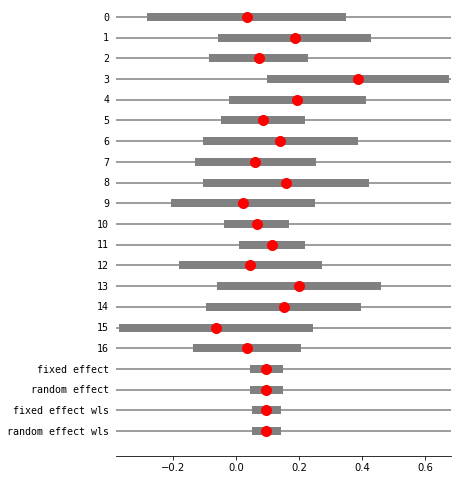

In [93]:
res5 = combine_effects(
    eff3, var_eff3, method_re="iterated", use_t=False
)  # , row_names=rownames)

res5_df = res5.summary_frame()

print("method RE:", res5.method_re)
print(res5.summary_frame())

fig = res5.plot_forest()
fig.set_figheight(8)

### Example of the reboxetine study

The analysis takes the data from the [article from Eyding et al. (2010)](https://www.bmj.com/content/341/bmj.c4737) discussed in page 455-456 and from which the forest plot in Figure 43.1 was derived.

method RE: chi2
RE variance tau2: 0.05605589416643271
                        eff    sd_eff    ci_low    ci_upp  w_fe  w_re
fixed effect       0.154119  0.089729 -0.021746  0.329984   1.0   NaN
random effect      0.160783  0.129872 -0.093762  0.415328   NaN   1.0
fixed effect wls   0.154119  0.125602 -0.092057  0.400295   1.0   NaN
random effect wls  0.160783  0.136132 -0.106032  0.427598   NaN   1.0


Text(0.5, 0, 'Odds ratio (95% CI)')

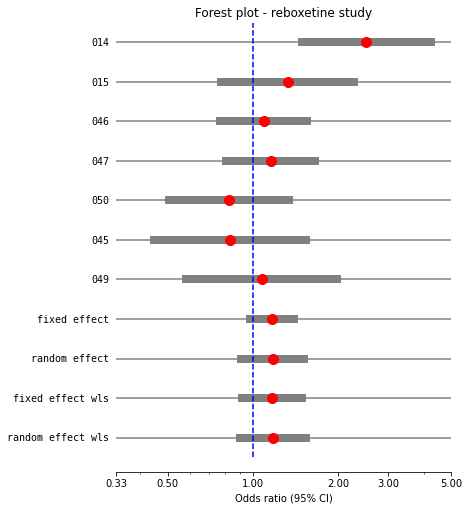

In [138]:
data_eyding = [
    ["014",  60, 126,  34, 128],
    ["015",  47, 110,  40, 111],
    ["046", 132, 252, 124, 247],
    ["047", 109, 238, 101, 239],
    ["050",  48, 144,  54, 143],
    ["045",  30,  88,  33,  86],
    ["049",  29, 106,  27, 104],
]
colnames_eyding = ["study", "count_t", "nobs_t", "count_c", "nobs_c"]
df_eyding = pd.DataFrame(data_eyding, columns=colnames_eyding).set_index('study')
# sample 1 is treatment and sample 2 is control

dta_eyding = df_eyding.values.T

eff_eyding, var_eff_eyding = effectsize_2proportions(*dta_eyding, statistic="or")
# log-odds-ratio and log-risk-ratio can be transformed back to or and rr using the exp function

res_eyding = combine_effects(
    eff_eyding, var_eff_eyding, method_re="chi2", use_t=False, row_names=df_eyding.index,
)

print("method RE:", res_eyding.method_re)
print("RE variance tau2:", res_eyding.tau2)
print(res_eyding.summary_frame().iloc[-4:])

fig = res_eyding.plot_forest(
    use_exp=True, # to show OR instead of logOR
)
fig.set_figheight(8)
plt.axvline(x=1, ls='--', color='blue')

plt.xscale('log')

ax = plt.gca()

# By default, a logarithmic scale uses a LogFormatter
from matplotlib.ticker import ScalarFormatter

ax.xaxis.set_major_formatter(ScalarFormatter())
ax.set_xticks([.33, .5, 1, 2, 3, 5])

ax.set_title('Forest plot - reboxetine study')
ax.set_xlabel('Odds ratio (95% CI)')

In [85]:
res_eyding.test_homogeneity()

<class 'statsmodels.stats.base.HolderTuple'>
statistic = 11.756574010710532
pvalue = 0.0676249431325276
df = 6
distr = 'chi2'
tuple = (11.756574010710532, 0.0676249431325276)

In [202]:
# with with odds ratio instead of log odds ratio
res_eyding_subframe = res_eyding.summary_frame().loc[:'random effect', ['eff', 'sd_eff', 'ci_low', 'ci_upp']]
round(res_eyding_subframe.apply(np.exp), 2)

,eff,sd_eff,ci_low,ci_upp
014,2.51,1.31,1.49,4.25
015,1.32,1.32,0.77,2.27
046,1.09,1.20,0.77,1.55
047,1.15,1.20,0.80,1.66
050,0.82,1.28,0.51,1.34
045,0.83,1.37,0.45,1.54
049,1.07,1.37,0.58,1.98
fixed effect,1.17,1.09,0.98,1.39
random effect,1.17,1.14,0.91,1.51


In [203]:
# Odds ratio
np.exp(res_eyding.eff)

array([2.51336898, 1.32420635, 1.09112903, 1.1545015 , 0.82407407,
       0.830721  , 1.07407407])

In [204]:
# 95% CI of the odds ratio
np.exp(res_eyding.conf_int_samples())

array([[1.48615459, 0.7707871 , 0.76800148, 0.80402743, 0.50784043,
        0.447326  , 0.58244518],
       [4.25058316, 2.2749764 , 1.55020869, 1.65774656, 1.3372273 ,
        1.5427169 , 1.98067586]])

In [205]:
# Weights for random-effect
res_eyding.weights_re / sum(res_eyding.weights_re)

array([0.13185003, 0.12749867, 0.19132125, 0.18713961, 0.14408635,
       0.10825823, 0.10984586])

In [206]:
res_eyding.weights_rel_re

array([0.13185003, 0.12749867, 0.19132125, 0.18713961, 0.14408635,
       0.10825823, 0.10984586])

#### Step-by-step

Similarly to the previous example with the Woolf method, we can calculate the different parameters using the standard error $\mathrm{SE}(\log \mathrm{OR}) = \sqrt{\frac{1}{n_{00}}+ \frac{1}{n_{01}} + \frac{1}{n_{10}} + \frac{1}{n_{11}}}$

In [210]:
# for example for stydy #014
data014 = data_eyding[0][1:]
print(data014)
se_log_or_014 = (1/data014[0] + 1/(data014[1] - data014[0]) + 1/data014[2] + 1/(data014[3]-data014[2]))**.5

[60, 126, 34, 128]


In [214]:
se_log_or_014

0.2680825328073513

In [213]:
(1/60+1/(126-60)+1/34+1/(128-34))**.5

0.2680825328073513

In [212]:
w_log_or_014 = 1 / se_log_or_014**2
w_log_or_014 

13.91435130214518

### Example of the `rmeta` mackage with the catheter dataset

In [24]:
catheter = pd.read_csv("https://raw.githubusercontent.com/sbwiecko/intro_statistique_R/master/data/catheter.csv", index_col=0)

catheter.head()

,Name,n.trt,n.ctrl,col.trt,col.ctrl,inf.trt,inf.ctrl
1,Ciresi,124,127,15.0,21.0,13.0,14.0
2,George,44,35,10.0,25.0,1.0,3.0
3,Hannan,68,60,22.0,22.0,5.0,7.0
4,Heard,151,157,60.0,82.0,5.0,6.0
5,vanHeerden,28,26,4.0,10.0,NaN,NaN


In [25]:
df_catheter = catheter[["Name", "n.trt", "n.ctrl", "col.trt", "col.ctrl"]].set_index("Name")
df_catheter = df_catheter.iloc[[12,5,4,2,6,11,3,10,0,7,9,1]]
df_catheter

,n.trt,n.ctrl,col.trt,col.ctrl
Name,,,,
Tennenberg,137,145,8.0,32.0
Maki,208,195,28.0,47.0
vanHeerden,28,26,4.0,10.0
Hannan,68,60,22.0,22.0
Bach(a),14,12,0.0,4.0
Bach(b),116,117,2.0,16.0
Heard,151,157,60.0,82.0
Collins,98,139,2.0,25.0
Ciresi,124,127,15.0,21.0


method RE: chi2
RE variance tau2: nan
                   eff    sd_eff  ci_low  ci_upp  w_fe  w_re
fixed effect       NaN  0.272896     NaN     NaN   1.0   NaN
random effect      NaN       NaN     NaN     NaN   NaN   1.0
fixed effect wls   NaN       NaN     NaN     NaN   1.0   NaN
random effect wls  NaN       NaN     NaN     NaN   NaN   1.0


C:\Users\WIECKOWS\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\stats\meta_analysis.py:492: RuntimeWarning: invalid value encountered in log
  log_or = np.log(p1) - np.log(1 - p1) - np.log(p2) + np.log(1 - p2)
C:\Users\WIECKOWS\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\stats\meta_analysis.py:492: RuntimeWarning: divide by zero encountered in log
  log_or = np.log(p1) - np.log(1 - p1) - np.log(p2) + np.log(1 - p2)
C:\Users\WIECKOWS\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\stats\meta_analysis.py:493: RuntimeWarning: divide by zero encountered in true_divide
  log_or_var = 1 / (p1 * (1 - p1) * n1) + 1 / (p2 * (1 - p2) * n2)
C:\Users\WIECKOWS\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\stats\meta_analysis.py:582: RuntimeWarning: invalid value encountered in sqrt
  sd_eff = np.sqrt(var_eff)


Text(0.5, 1.0, 'Forest plot - Catheter dataset')

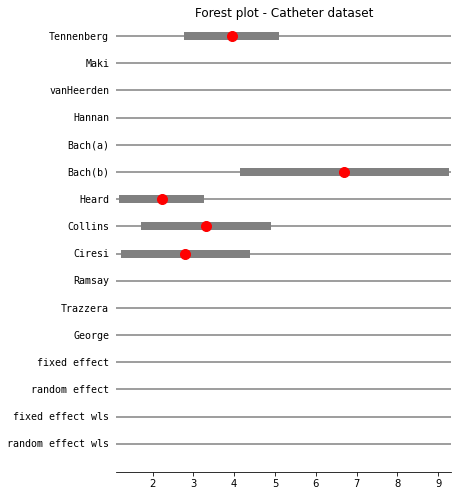

In [26]:
eff_catheter, var_eff_catheter = effectsize_2proportions(*df_catheter.values.T, statistic="or")

res_catheter = combine_effects(
    eff_catheter, var_eff_catheter, method_re="chi2", use_t=False, row_names=df_catheter.index,
)

print("method RE:", res_catheter.method_re)
print("RE variance tau2:", res_catheter.tau2)
print(res_catheter.summary_frame().iloc[-4:])

fig = res_catheter.plot_forest()
fig.set_figheight(8)
plt.gca().set_title('Forest plot - Catheter dataset')

### Mantel-Haenszel method

When data are sparse, either in terms of event risks being low or study size being small, the estimates of the standard errors of the effect estimates that are used in the inverse-variance methods may be poor. Mantel-Haenszel methods are fixed-effect meta-analysis methods using a different weighting scheme that depends on which effect measure (e.g. risk ratio, odds ratio, risk difference) is being used (Mantel and Haenszel 1959, Greenland and Robins 1985). They have been shown to have better statistical properties when there are few events. As this is a common situation in Cochrane Reviews, the Mantel-Haenszel method is generally preferable to the inverse variance method in fixed-effect meta-analyses. In other situations the two methods give similar estimates.

### Funnel plots

A funnel plot is a graph designed to check for the existence of publication bias; funnel plots are commonly used in systematic reviews and meta-analyses. In the absence of publication bias, it assumes that studies with high precision will be plotted near the average, and studies with low precision will be spread evenly on both sides of the average, creating a roughly funnel-shaped distribution. Deviation from this shape can indicate publication bias.

In [27]:
from funnelplot.core import funnel


## Meta-analysis of individual participant data (IPD meta-analysis)

A newer approach is for the meta-analysts to obtain the original data for each participant of each study, and reanalyze all the data together. This approach is considered the gold standard of meta-analysis and has determined definitive answers to clinical questions, which might not have been obtained from meta-analysis of summay data. This type of analysis ensures that the outcomes are defined in a consistent way, and that the data are analyzed using the same methods. Moreover, it can include more data than did the original paper because one get data at the root from the investigators, it can answer questions not posed by the original investigators, run subgroup analyses and account for confounding variables not considered by the original investigators.